In [21]:
import os
import hdf5storage as h5
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import ImageEnhance
import random

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import models
from torchvision.transforms import functional as F

# REVIEWING TRANSFORMATIONS

In [22]:
SLICES = {
	"Base" : 0,
	"Mid" : 1,
	"Apex" : 2,
}

class DataSet(Dataset):
    """
    Dataset processing with various affine data augmentation possibilities. 
    Transforms for keypoint programmed from scratch using affine matrices
    """
    def __init__(self, data_folder, degrees=None, translate=None, scale=None, contrast=1, flipping=False, no_midpoint=False, filter_level=0):
		
        assert os.path.exists(data_folder), 'Folder not present'
		
        self.data_folder = os.path.abspath(data_folder)

        # Filter the data files
        if filter_level == 0:
            self.data_files = os.listdir(data_folder)
        else:
            self.data_files = []
            temp_data_files = os.listdir(data_folder)
            for file in temp_data_files:
                data = h5.loadmat(os.path.join(self.data_folder, file))
                if filter_level == 1 and data["Notes"] != "Low Qual.":
                    self.data_files.append(file)
                elif filter_level == 2 and data["Notes"] not in ["Low Qual.", "Questionable Qual."]:
                    self.data_files.append(file)

        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.contrast = contrast
        self.flipping = flipping
        
        self.no_midpoint = no_midpoint

    def __len__(self):
        return len(self.data_files)

    def affine_transform(self, image, label, degrees=None, translate=None, scale=None):
        degrees = 0 if degrees is None else degrees
        translate = 0 if translate is None else translate
        scale = 0 if scale is None else scale
        
        # https://en.wikipedia.org/wiki/Affine_transformation
        r, t, sc, sh = transforms.RandomAffine.get_params(degrees=(-degrees, degrees), translate=(translate, translate), scale_ranges=(1-scale, 1+scale), shears=(0, 0), img_size=(200, 200))
        theta = np.radians(r) 

        # Translation values
        tx = t[0]
        ty = t[1]

        cx = 200 / 2
        cy = 200 / 2

        # Calculate elements of the rotation matrix
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)

        tx_center = cx - sc * (cx * cos_theta - cy * sin_theta)
        ty_center = cy - sc * (cx * sin_theta + cy * cos_theta)


        # Create the scale + rotation matrix
        R = np.array([[sc * cos_theta, sc * -sin_theta],
                    [sc * sin_theta, sc * cos_theta]])

        # Create the translation vector
        T = np.array([tx_center, ty_center])

        # Create the affine matrix
        A = np.zeros((3, 3))
        A[:2, :2] = R
        A[:2, 2] = T
        A[2, 2] = 1

        A = torch.Tensor(A)

        num_points = 2 if self.no_midpoint else 3

        # Create format for transformation to apply to 
        homogeneous_label = torch.cat((label, torch.ones(num_points, 1)), dim=1)

        # Apply the transformation matrix to the label points
        transformed_label = torch.mm(A, homogeneous_label.t()).t()

        # Convert the transformed label points back to Cartesian coordinates
        transformed_label = transformed_label[:, :2]

        # NOTE: input y and x are swapped
        transformed_label += torch.tensor([[ty, tx] for _ in range(num_points)])

        transformed_image = F.affine(image, angle=-r, translate=(tx, ty), scale=sc, shear=sh, fill=0, center=(cx, cy))
        
        return [transformed_image, transformed_label]

    def __getitem__(self, index):
        data = h5.loadmat(os.path.join(self.data_folder, self.data_files[index]))

        pil_image = Image.fromarray(data['NiFTi'].astype(np.uint8))

        # Apply random contrast
        contrast_factor = random.uniform(1/self.contrast, self.contrast) 
        enhancer = ImageEnhance.Contrast(pil_image)
        pil_image = enhancer.enhance(contrast_factor)

        # ignores Mid_Septum if no_midpoint is toggled
        if self.no_midpoint:   
            label = torch.Tensor([data['Anterior_RVIP'][0], data['Inferior_RVIP'][0]])
        else:
            label = torch.Tensor([data['Anterior_RVIP'][0], data['Inferior_RVIP'][0], data['Mid_Septum'][0]])
        

        # Randomly decide whether to flip the image and points
        if self.flipping and random.choice([True, False]):
            pil_image = F.hflip(pil_image)

            for i in range(len(label)):
                label[i][1] = 200 - label[i][1]

            print("Flipped")

        NifTi, label = self.affine_transform(pil_image, label, self.degrees, self.translate, self.scale)

        label = (label / 200).flatten().to(torch.float32)
        NifTi = transforms.ToTensor()(NifTi)[0]


        slice = torch.from_numpy(np.array(SLICES[data['Slice_Location'][0]]))

        return NifTi, slice, label


In [23]:
data_path = './data/train'

rotation = 90
translation = 0.1
scale = 0.1
contrast = 2
flipping = True
no_midpoint = False

transformed_dataset = DataSet(data_path, degrees=rotation, translate=translation, scale=scale, contrast=contrast, flipping=flipping, no_midpoint=no_midpoint)
original_dataset = DataSet(data_path, no_midpoint=no_midpoint)

Flipped
tensor([ 58.0000, 118.0000,  82.0000,  84.0000,  62.0000,  96.0000])


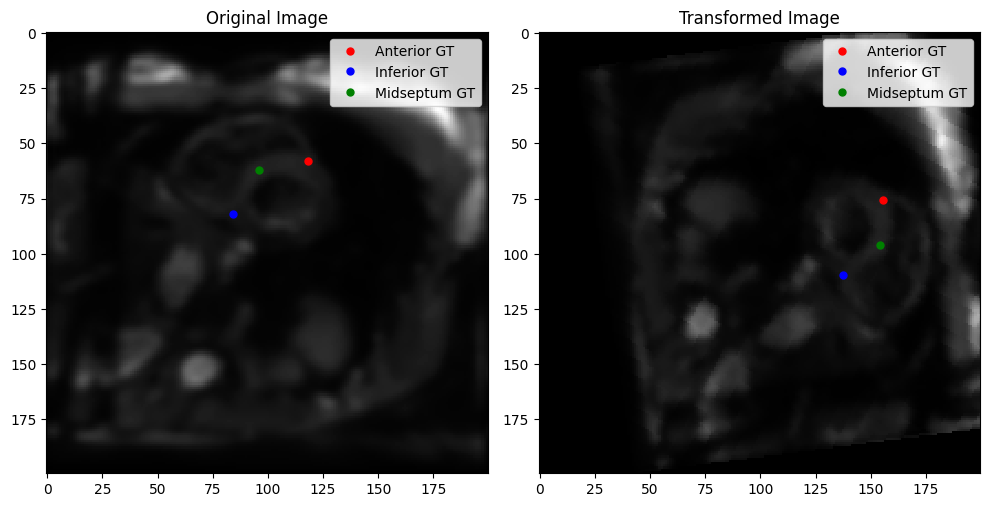

In [24]:
transform_NifTi, transform_slice, transform_label = transformed_dataset.__getitem__(0)
original_NifTi, original_slice, original_label = original_dataset.__getitem__(0)

transform_label *= 200
original_label *= 200
print(original_label)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Original Image
axs[0].imshow(original_NifTi, interpolation='nearest', cmap="gray")
axs[0].plot(original_label[1], original_label[0], 'ro', markersize=5, label='Anterior GT')
axs[0].plot(original_label[3], original_label[2], 'bo', markersize=5, label='Inferior GT')
axs[0].set_title('Original Image')

# Transformed Image
axs[1].imshow(transform_NifTi, interpolation='nearest', cmap="gray")
axs[1].plot(transform_label[1], transform_label[0], 'ro', markersize=5, label='Anterior GT')
axs[1].plot(transform_label[3], transform_label[2], 'bo', markersize=5, label='Inferior GT')
axs[1].set_title('Transformed Image')

if not no_midpoint:
  axs[0].plot(original_label[5], original_label[4], 'go', markersize=5, label='Midseptum GT')
  axs[1].plot(transform_label[5], transform_label[4], 'go', markersize=5, label='Midseptum GT')

# Add legend
axs[0].legend()
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()